# Setup

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# MNIST

In [2]:
from scipy.io import arff
import pandas as pd
import numpy as np

data, meta = arff.loadarff("data/mnist_784.arff")

df = pd.DataFrame(data)

X = df.iloc[:, :-1].values.astype(np.float32)  
y = df.iloc[:, -1].values.astype(str)  

y = np.array([int(label) for label in y])




In [3]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. Each iamge = 28 x 28 pixels = 784 features, each feature one pixel's intensity from 0 (white) yo 255 (black)

In [5]:
y

array([5, 0, 4, ..., 4, 5, 6])

In [6]:
y.shape

(70000,)

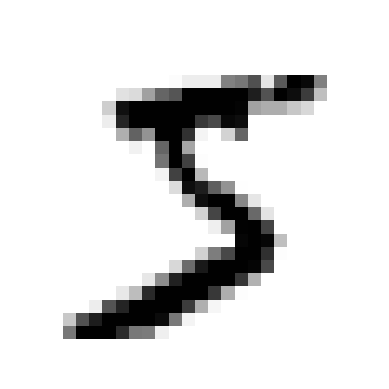

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

5

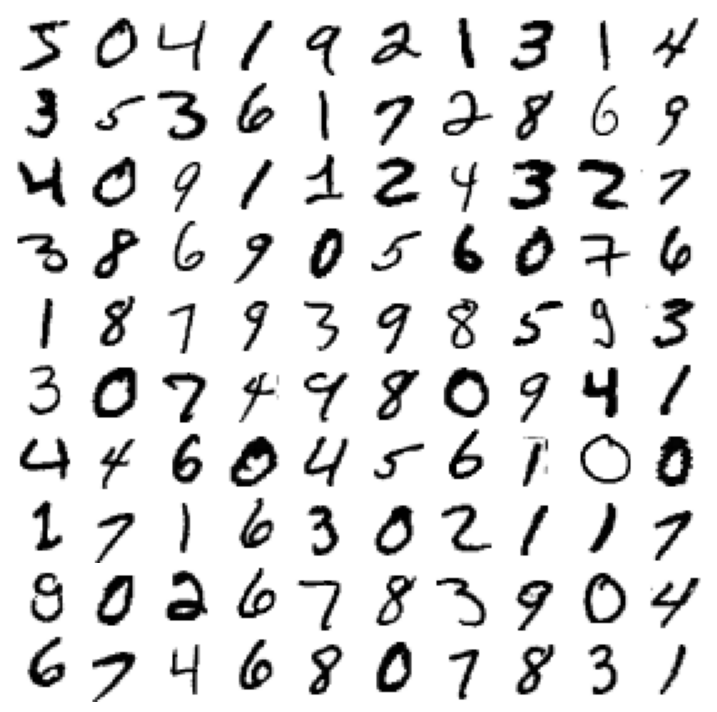

In [9]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [11]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now we'll pick a classifier and train it. For example a stochastic gradient descent "SGD"

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

some_digit = X[0] --> first digit of the dataset --> digit = 5

In [13]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case!

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9353 , 0.9632 , 0.94965])

For more control over the cross-validation you could alternatively

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9353
0.9632
0.94965


What would happen if we clasiffy every single image in the most frequent class, in this case the negative class (non 5)?

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Only about 10% of the images were 5s, so if you always guess that an image is not 5, you will be right about 90% of the time. This is why accuracy is generally not the preferred performance measure for classifiers

A better way to evaluate the performance of a classifier is the confusion matrix (CM)

### Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[52533,  2046],
       [  991,  4430]])

Each row represents an actual class, while each column represents a predicted class

- First row = non-5 images
- Second row = 5 images
- First column = Prediction of a non-5 image
- Second column = Prediction of  a 5 image

- 52533 images were correctly classified as non-5 (True Negatives)
- 2046 images were wrongly classified as a 5 beeing a non-5 (False Positives - type 1 error)
- 991 images were wrongly classified as a non-5 beeing a 5 (False Negatives - type 2 error)
- 4430 images were correctly classified as a 5 (True Positives)


This is how a perfect classifier would look like (only TN and TP):

In [20]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

precision = TP / (TP + FP); of all positives predicted, how many were true?

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 4430/(4430+2046)

0.6840642371834466

In [22]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.6840642371834466

recall = TP / (TP + FN); of all real positives, how many were correctly detected by the classifier?

In [23]:
recall_score(y_train_5, y_train_pred)  # == 4430 / (4430 + 991)

0.8171923999262128

In [24]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.8171923999262128

- When it claims an image represents a 5, it is correct 68% of the time (precision)
- It detects 81% of the 5s (recall)

To combine precision and recall into a single metric --> F1 score
- F1 score = harmonic mean of precision and recall (harmonic mean = it gives much more weight to low values)
- For a high F1 score, both recall and precision must be high

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7447255610658149

In [26]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7447255610658149

F1 favors classifiers that have similar precision and recall

In some cases, you will only care about precision and in other cases you will really care about recall

-  High precision --> all claims made were correct
- High recall --> it detects all the real positives

Increasing precision reduces recall, and vice versa --> precision/recall trade-off

### Precision/Recall Trade-off

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2871.11767087])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [29]:
y_some_digit_pred

array([ True])

It detects that the image is a 5 when threshold is set at 0

In [30]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

It misses that the image is a 5 when threshold is set at 3000

Therefore, raising the threshold decreases recall but increases precision, and vice versa
- How do you decide which threshold to use?

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

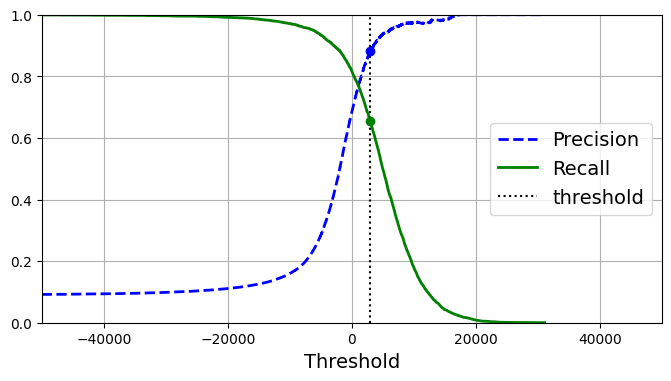

In [33]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")


idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall

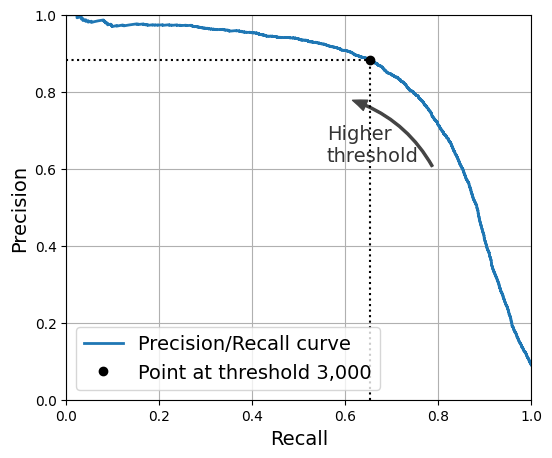

In [34]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")


plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

You can see on the plots what precision/recall trade-off you'd like and select the threshold accordingly
- This will depend on your project.

Suppose that after looking at the plot, you decide to aim for 90% precision. Then, you could search for the lowest threshold that gives you at least 90% precision (lowering the threshold increases recall):

In [35]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3533.1791790603324

To make predictions on the training set:

In [36]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let's check predictions recall and precision

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9001888319395738

In [38]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.6155690831949825

### The ROC Curve

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

The ROC curve plots sensitivity (recall) against 1 - specificity (true negative rate)

- true negative rate (TNR) = ratio of negative instances correctly cassified as negative
- FPR (false positive rate or fall-out) = 1 - TNR --> ratio of negative instances incorrectly cassified as positive

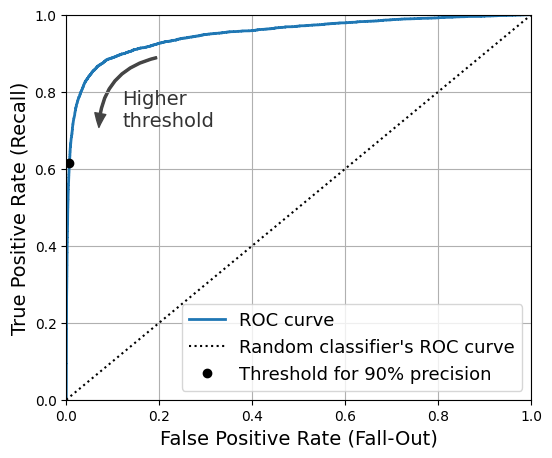

In [40]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")


plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

Trade off --> the higher the recall, the more false positives the classifier produces

One way to compare classifiers is to measure the area under the curve (AUC). 
- Perfect classifier --> AUC = 1
- Purely random classifier --> AUC = 0.5

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9506700868666318

How to decide if we use the precision/recall curve (PR) or the ROC curve?

- PR curve --> when the positive class is rare (not many real positives in the sample) or when you care more about the false positives than the false negatives.

- ROC curve --> Otherwise

e.g. looking at the AUC score, you may think that this classifier is very good, but this is because there are few positives (5s) compared to the negatives (non-5). See that the PR curve shows that the classifier has room for improvement (if curve moves to the right corner).

Let´s now create a RandomForestClassifier, whose PR curve and F1 score we can compare to the SGDClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [43]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [44]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

RandomForestClassifier does not have a decision_function() but instead it has a predict_proba() method that returns class probabilities for each instance.

- We can use the probability of the positive class as a score

y_probas_forest
- The model predicts that the first image is positive with 89% probability.
- It also predicts that the second image is negative with 99% probability.
- Since an image is etiher positive or negative, both probailities add up to 100%

These are estimated probabilities. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% (actual probability) positive images:

In [45]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [46]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The second column contains the estimated proabilities (not actual probabilities as seen before) for the positive class (the probability of been a 5), so lets pass them to te PR function

In [47]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

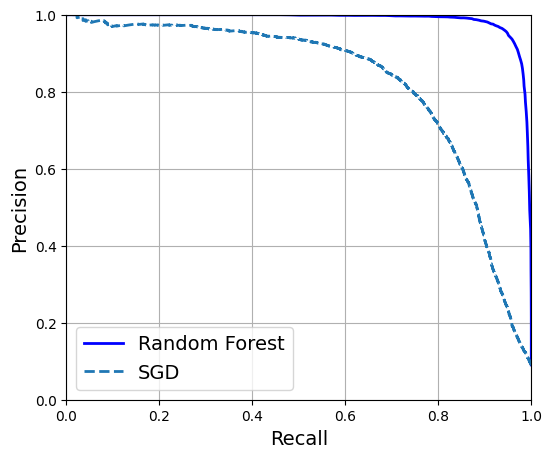

In [48]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Random Forest Classifier looks much better than the SGDClassifier, it comes much closer to the top-right corner. Its F1 score and ROC AUC score are also significantly better

We could use cross_val_predict(forest_clf, X_train, y_train_5, cv=3) to compute y_train_pred_forest, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [49]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [51]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

We learnt how to train a binary classifier, now let's move to detect more than just the 5s

## Multiclass Classification

Multiclass classifiers (multinomial classifiers) can dstinguish between more than two classes

Classifiers capable of handling multiple classes:
- Logistic Regression
- Random Forest
- Gaussian NB

Binary Classifiers (OvR or Ovo strategy to perform multiclass classification with multiple binary classifiers):
- SDG Classifier
- SVC: Support Vector Machine Classifier

Let´s try a support vector machine classifier first

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [53]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

We trained the SVC using the original target classes from 0 to 9

In [54]:
svm_clf.predict([some_digit])

array([5])

For the instance, some digit (a 5), it returns 10 different scores, as we have 10 different numbers (0 to 9) in the sample to compared to. 

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

As we see, the highest score 9.3 is in the 5th position of the index, representing that the 5 got the higher score. And indeed is a 5.

In [56]:
class_id = some_digit_scores.argmax()
class_id

5

In [57]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [58]:
svm_clf.classes_[class_id]

5

	
If you want decision_function() to return all 45 scores, you can set the decision_function_shape hyperparameter to "ovo". The default value is "ovr", but don't let this confuse you: SVC always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [59]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use OneVsOneClassifier or OneVsRestClassifier classes. For example this code creates a multiclass classifier ussing OvR strategy, based on an SVC

In [60]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [61]:
ovr_clf.predict([some_digit])

array([5])

In [62]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy:

In [63]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5])

In [64]:
sgd_clf.decision_function([some_digit]).round()

array([[-23631., -24084., -18695.,  -4394., -19634.,   -367., -24506.,
         -9919.,  -9544., -12887.]], dtype=float32)

You can see that the classifier is not very confident about its prediction: almost all scores are very negative and it chose "5" correctly because it was the least negative score.

Warning: the following two cells may take a few minutes each to run:

In [65]:
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It got over 84.84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can do it much better just by SCALING the inputs (Chapter 2)

In [66]:
'''from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")'''

'from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train.astype("float64"))\ncross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")'

### Error Analysis

Following our project checklist, we will assume that we have found a promising model and want to find ways to improve it.

- One way is to analze the types of error it makes

First, let's look at the confusion matrix

Warning: the following cell will take a few minutes to run:

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

NameError: name 'X_train_scaled' is not defined

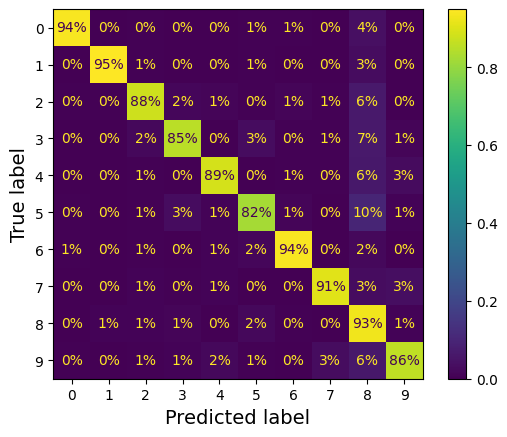

In [ ]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

Now we can see that only 82% of the images of 5s were classified correctly. The most common error the model made with images of 5s was to misclassify them as 8s, this happened 10% of all 5s. But only 2% of 8s got misclassified as 5s (confusion matrices are usually not symetrical)

If you want to make the errors stand out more, you can try putting 0 weight on the correct predictions:

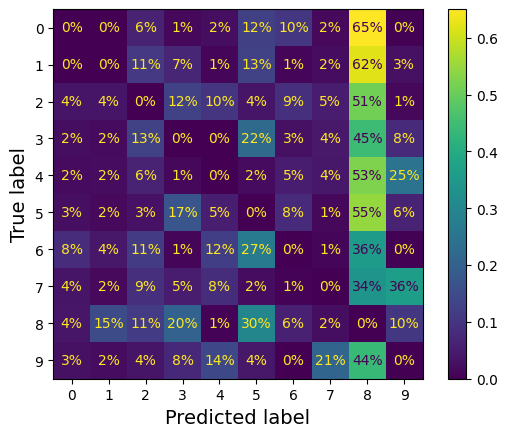

In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

How to read it: 
- For example, 36% of the errors the model made on images of 7s were misclassified as 9s.
- It does not mean that 36% of all images of 7s were misclassified as 9s, since this info was in the previous matrix, been only 3% of all images of 7s which were missclasified as 9s
- Column 8 is quite bright which means that many images were misclassified as 8s.

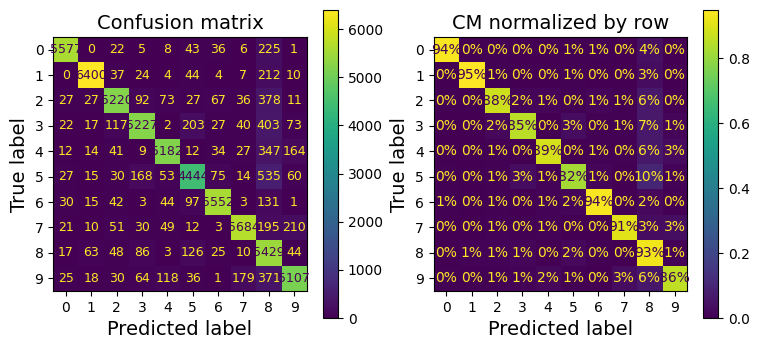

In [ ]:
# extra code – this cell generates and saves Figure 3–9
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
plt.show()

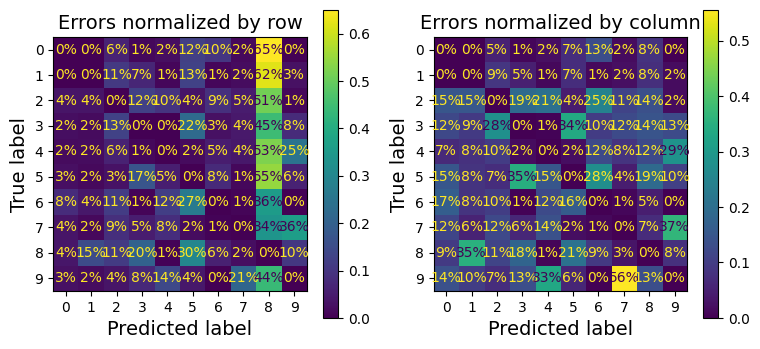

In [ ]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
plt.show()
plt.rc('font', size=14)  # make fonts great again

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at these plots, it seems taht your efforts should be spent on reducing the false 8s.

- E.g. we could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s

Analyzing individual errors can aslo be a good way to gain insights into what your classifier is doing and why its failing

In [88]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

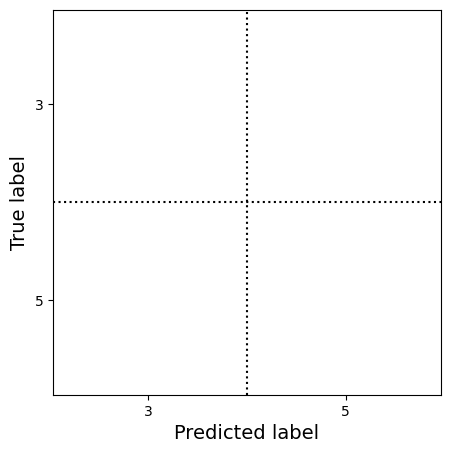

In [90]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

We can see that some of the digits the classifier gets wrong are so badly written that even a human would have trouble classifying them

### Multilabel Classification

Sometimes we want our classifier to output multiple classes for each instance

In [73]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code created a y_multilabel array containing two target labels for each digit image: the first indicates wether or not the digit is large (7,8, or 9) and the second whether or not is odd

KNeighborsClassifier supports multilabel classification (not all classifiers do)

Let's make a prediction. Warning: the following cell may take a few minutes to run:

In [91]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

"macro" assumes that all labels are equally important, which may not be the case. If we want to give each label a weight equal to its support then use average = "weighted"

In [92]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

If we wish to use a classifier that does not natively support multilabel classification, such as SVC, be can organize the models in a chain:

In [93]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [94]:
chain_clf.predict([some_digit])

array([[0., 1.]])

It predicted that the number is not large but is odd

### Multioutput Classification

In [95]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

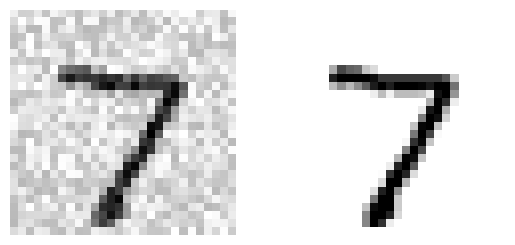

In [97]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

plt.show()

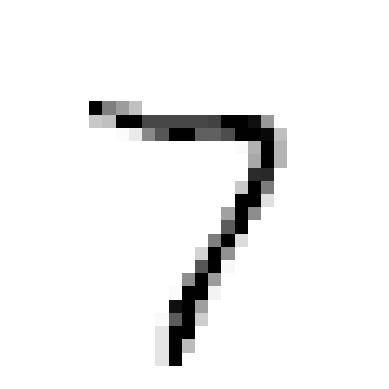

In [98]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

plt.show()